# Experiment: Clustering Method

This shows that Leiden suited for clustering scRNA-seq data, while clustering with Kmeans of scRNAseq data fails due to a high amount of outliers, which lead to many single sample clusters.
Further, we seee that normalization and log1p transformation is needed to find clusters at all. (BTW, KMedoids or DBSCAN does not work entirely as clustering method)

For this, we use a subsample ($n=1000$) of breast cancer scRNAseq from Wu et al. 2021.

In [2]:
from beartype.vale import IsInstance

import pyprism
from pathlib import Path
import scanpy as sc
import numpy as np
import anndata as ad
from anndata import AnnData
from numpy import float32, float64, array, repeat
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
import matplotlib.pyplot as plt

In [ ]:
def kmeans_sucks():
    def preprocessing_pipeline(subsample: int | None = None) -> ad.AnnData:
        
        store = pyprism.store.Store(path=Path("../store"))
        adata = pyprism.datasets.WuEtAl2021(store=store).get("GSM5354522")
        adata = adata[~adata.obs_names.duplicated()].copy()
        
        if subsample is not None:
            adata = pyprism.utils.sample_adata(adata, subsample)
        
        return adata
    
    adata = preprocessing_pipeline(subsample = 1000)
    adata_normalized = sc.pp.normalize_total(adata, copy=True)
    adata_log = sc.pp.log1p(adata_normalized, copy=True)
    
    def calc_kmeans_centroids(adata: AnnData, n_clusters: int) -> AnnData:
        """
        WARNING: Potentially not fully deterministic!!!
        Tried to make it deterministic by going to 64 bit floats as with 32 bits one get random deviations of one or two eps (i.e. machine precisions).
        """
        adata.X = adata.X.astype(dtype=float64)
        estimator = KMeans(n_clusters=n_clusters, init="k-means++", random_state=0, n_init=1)
        # estimator = KMedoids(n_clusters=n_clusters, init="k-medoids++", random_state=0)
        prediction = estimator.fit_predict(adata.X)
        cluster_centers = array(estimator.cluster_centers_, dtype=float32)
        cluster_centers = AnnData(cluster_centers)
        cluster_centers.var_names = adata.var_names
        cluster_centers.obs_names = ["cluster_{}".format(i) for i in range(n_clusters)]
        cluster_centers.obs["cluster_method"] = repeat("kmedoids", cluster_centers.n_obs)
        return cluster_centers, prediction

    cell_centroids_log, cluster_indicies = calc_kmeans_centroids(adata_log, n_clusters=10)
    
    def plot_umap_with_cluster_centroids(adata, cluster_centroids, zero_center_in_pca: bool = False, n_comps_in_pca: int = 50):
        
        adata.obs["cluster_method"] = None
        cluster_centroids.obs["cluster_indicies"] = cluster_centroids.n_obs
        adata = ad.concat([adata, cluster_centroids], axis=0, join="outer")
    
        sc.pp.pca(adata, n_comps=n_comps_in_pca, zero_center=zero_center_in_pca, svd_solver="arpack", copy=False, mask_var=None, chunked=True, random_state=0)
        sc.pp.neighbors(adata, random_state=0)
        sc.tl.umap(adata, random_state=0)
        sc.tl.leiden(adata, flavor="igraph", n_iterations=-1, resolution=1.0, random_state=0)
        
        adata.obs["leiden+cluster_method"] = [cluster_method if cluster_method is not None else leiden for leiden, cluster_method in zip(adata.obs["leiden"], adata.obs["cluster_method"])]
        
        adata.obs["cluster_indicies"] = adata.obs["cluster_indicies"].astype(str)
        
        sc.pl.umap(
            adata,
            color=["cluster_method", "leiden", "leiden+cluster_method", "celltype_major", "cluster_indicies"],
            # Setting a smaller point size to get prevent overlap
            size=50,
            ncols=3
        )
    
    adata_log.obs["cluster_indicies"] = cluster_indicies
    plot_umap_with_cluster_centroids(adata_log, cell_centroids_log)
    
    print(np.unique(cluster_indicies, return_counts=True))

kmeans_sucks()

Here, we see that most clusters are actually single sample clusters.

So, let's try leiden instead!

In [ ]:
def leiden_is_better():
    def preprocessing_pipeline(subsample: int | None = None) -> ad.AnnData:
        
        store = pyprism.store.Store(path=Path("../store"))
        adata = pyprism.datasets.WuEtAl2021(store=store).get("GSM5354522")
        adata = adata[~adata.obs_names.duplicated()].copy()
        
        if subsample is not None:
            adata = pyprism.utils.sample_adata(adata, subsample)
        
        return adata
    
    adata = preprocessing_pipeline(subsample = 1000)
    adata_normalized = sc.pp.normalize_total(adata, copy=True)
    adata_log = sc.pp.log1p(adata_normalized, copy=True)
    
    def calc_leiden_centroids(adata: AnnData, n_comps_in_pca: int = 100, resolution: float = 5.0, random_state: int = 0) -> AnnData:
        """
        WARNING: Potentially not fully deterministic!!!
        Tried to make it deterministic by going to 64 bit floats as with 32 bits one get random deviations of one or two eps (i.e. machine precisions).
        """
        adata.X = adata.X.astype(dtype=float64)
        
        sc.pp.pca(adata, n_comps=n_comps_in_pca, zero_center=False, svd_solver="arpack", copy=False, mask_var=None, chunked=True, random_state=random_state)
        sc.pp.neighbors(adata, random_state=random_state)
        sc.tl.leiden(adata, flavor="igraph", n_iterations=-1, resolution=resolution, random_state=random_state)
        
        cluster_idicies = np.unique(adata.obs["leiden"].to_numpy())
        number_of_clusters = len(cluster_idicies)
        
        kmeans_clusters_per_leiden_cluster = 1
        cluster_centers = np.zeros(shape=(kmeans_clusters_per_leiden_cluster*number_of_clusters, adata.n_vars))
        for index in cluster_idicies:
            index = int(index)
            estimator = KMeans(n_clusters=kmeans_clusters_per_leiden_cluster, init="k-means++", random_state=0, n_init=1)
            _ = estimator.fit_predict(adata[adata.obs["leiden"]==str(index)].X)
            cluster_centers[kmeans_clusters_per_leiden_cluster*index:kmeans_clusters_per_leiden_cluster*(index+1), :] = array(estimator.cluster_centers_, dtype=float32)
        
        cluster_centers = AnnData(cluster_centers)
        cluster_centers.var_names = adata.var_names
        cluster_centers.obs_names = ["centroid_kmeans-{}_leiden-{}".format(i, j) for j in range(number_of_clusters) for i in range(kmeans_clusters_per_leiden_cluster)]
        cluster_centers.obs["cluster_method"] = repeat("kmedoids", cluster_centers.n_obs)
        return cluster_centers
    
    cell_centroids_log = calc_leiden_centroids(adata_log)

    def plot_umap_with_cluster_centroids(adata, cluster_centroids, zero_center_in_pca: bool = False,
                                         n_comps_in_pca: int = 50):
    
        adata.obs["cluster_method"] = None
        cluster_centroids.obs["cluster_indicies"] = cluster_centroids.n_obs
        adata = ad.concat([adata, cluster_centroids], axis=0, join="outer")
    
        sc.pp.pca(adata, n_comps=n_comps_in_pca, zero_center=zero_center_in_pca, svd_solver="arpack", copy=False,
                  mask_var=None, chunked=True, random_state=0)
        sc.pp.neighbors(adata, random_state=0)
        sc.tl.umap(adata, random_state=0)
        #sc.tl.leiden(adata, flavor="igraph", n_iterations=-1, resolution=1.0, random_state=0)
    
        sc.pl.umap(
            adata,
            color=["cluster_method", "celltype_major", "leiden"],
            # Setting a smaller point size to get prevent overlap
            size=50,
            ncols=2
        )
    
    
    plot_umap_with_cluster_centroids(adata_log, cell_centroids_log)
    
    cluster_stats = np.unique(adata_log.obs["leiden"], return_counts=True)
    print(cluster_stats)
    plt.figure(figsize=(10, 4))
    plt.hist(cluster_stats[1], bins=len(cluster_stats[0]))
    plt.show()
    
leiden_is_better()

Let's try kmeans after outlier detection

In [5]:
def preprocessing_pipeline(subsample: int | None = None) -> ad.AnnData:
    
    store = pyprism.store.Store(path=Path("../store"))
    adata = pyprism.datasets.WuEtAl2021(store=store).get("GSM5354522")
    adata = adata[~adata.obs_names.duplicated()].copy()
    
    if subsample is not None:
        adata = pyprism.utils.sample_adata(adata, subsample)
    
    return adata

adata = preprocessing_pipeline(subsample = 1000)
adata_normalized = sc.pp.normalize_total(adata, copy=True)
adata_log = sc.pp.log1p(adata_normalized, copy=True)

In [6]:
adata

AnnData object with n_obs × n_vars = 1000 × 29733
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'subtype', 'celltype_subset', 'celltype_minor', 'celltype_major'
    uns: 'gsm_metadata'

In [23]:
from sklearn.neighbors import LocalOutlierFactor

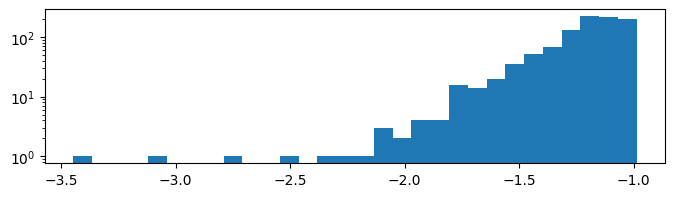

In [31]:
clf = LocalOutlierFactor(n_neighbors=20)
clf.fit_predict(adata.X)
plt.figure(figsize=(8,2))
plt.hist(clf.negative_outlier_factor_, bins=30)
plt.yscale("log")
plt.show()

In [66]:
bdata_log = adata_log[clf.negative_outlier_factor_ > -1.20, :].copy()
bdata_log

AnnData object with n_obs × n_vars = 578 × 29733
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'subtype', 'celltype_subset', 'celltype_minor', 'celltype_major'
    uns: 'gsm_metadata', 'log1p'

In [71]:
from scipy.sparse._csc import csc_matrix

def calc_kmeans_centroids(adata: AnnData, n_clusters: int) -> AnnData:
    """
    WARNING: Potentially not fully deterministic!!!
    Tried to make it deterministic by going to 64 bit floats as with 32 bits one get random deviations of one or two eps (i.e. machine precisions).
    """
    adata.X = adata.X.astype(dtype=float64)
    # estimator = KMeans(n_clusters=n_clusters, init="k-means++", random_state=0, n_init=1)
    estimator = KMedoids(n_clusters=n_clusters, init="k-medoids++", random_state=0)
    prediction = estimator.fit_predict(adata.X)
    if isinstance(estimator.cluster_centers_, csc_matrix):
        cluster_centers = array(estimator.cluster_centers_.todense(), dtype=float32)
    else:
        cluster_centers = array(estimator.cluster_centers_, dtype=float32)
    cluster_centers = AnnData(cluster_centers)
    cluster_centers.var_names = adata.var_names
    cluster_centers.obs_names = ["cluster_{}".format(i) for i in range(n_clusters)]
    cluster_centers.obs["cluster_method"] = repeat("kmedoids", cluster_centers.n_obs)
    return cluster_centers, prediction

cell_centroids_log, cluster_indicies = calc_kmeans_centroids(bdata_log, n_clusters=100)
np.unique(cluster_indicies, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 array([  1,   1,   2,   1,   1,  23,   9,   1,   1,   1,   1,   3,   1,
          1,   1,   1,   4,   3,   1,   1,   1,   1,   1,   4,   1,  37,
          1,   1,   2,   1,   1,   1,   1,  19,   1,  51,  17,  16,   1,
          1,   1,  24, 109,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,  14,   1,   1,   1,   1,   1,   1,  14,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   3,   1, 136,   1,
          1,   1,   1,   1,   2,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,  

In [74]:
adata.obsm

AxisArrays with keys: 

In [21]:
np.where(cluster_indicies==0)

(array([548]),)

In [22]:
adata.obs.iloc[548]

orig.ident                   CID4067
nCount_RNA                      1648
nFeature_RNA                     930
percent.mito               13.410194
subtype                          ER+
celltype_subset       Cancer LumB SC
celltype_minor        Cancer LumB SC
celltype_major     Cancer Epithelial
Name: CID4067_TGCCCTAGTCAATGTC, dtype: object